This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import pydelfi.score as score

tfd = tfp.distributions
tfb = tfp.bijectors

def find_level(nums, level):
    """
    Function to find confidence levels 
    """
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num
        
def lognorm(data, mean, sigma):
    """
    Function to draw the posterior from samples
    """
    pref = data*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(data)-mean)**2 / (2*sigma**2))
    return expo/pref

def real_post(sigma, mean, obs):
    """
    Function to draw the real posterior for the toy model only
    """
    pref = obs*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(obs)-mean)**2 / (2*sigma**2))
    evidence = 1 #inc_gamma(0, np.log(obs)**2 / 2) / (2*obs*np.sqrt(2*np.pi))
    return (expo/pref)/(evidence)

%matplotlib inline

In [3]:
# we define a few hyper parameters here
np.random.seed(13)
n = 1000 # total number of data points for compression
n_sims = 1000
n_class = 1 # number of different cosmologies for the training
q_prior = np.linspace(0.18, 0.22, n_sims)#np.random.uniform(0, 1, n)
q_posterior = np.copy(q_prior)
q_fid = np.random.uniform(0, 1, 1)

In [4]:
q_fid 

array([0.77770241])

In [5]:
# we need to create n observations at the fiducial point
# then, we calculate their mean and covariance matrix for now

n_vec = 50 # number of components of the data
d_vec = []
for _ in range(n):
    d_vec.append([np.random.lognormal(q_fid, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])

d_vec = np.reshape(np.asarray(d_vec), [-1, n_vec])
mu = np.mean(d_vec, axis=0)
cov = np.cov(d_vec, rowvar=False)
Cinv = np.linalg.inv(cov)

# then we also measure the derivative, which means
# we define a small step h, and calculate the difference in the mean
# with respect to that step

h = 0.01
q_fid_p = q_fid + h
d_vec_p = []
for _ in range(n):
    d_vec_p.append([np.random.lognormal(q_fid_p, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])
    
# we also create the data corresponding to fixed noise, at the fiducial q
d_vec_q_shift = []
for _ in range(1):
    np.random.seed(13)
    d_vec_q_shift.append([np.random.lognormal(q_fid, (i/n_vec)/100.0, 1) for i in range(n_vec)])

d_vec_p = np.reshape(np.asarray(d_vec_p), [-1, n_vec])
d_vec_q_shift = np.reshape(np.asarray(d_vec_q_shift), [-1, n_vec])
mu_p = np.mean(d_vec_p, axis=0)
dmudt = mu_p - mu
dmudt = np.reshape(dmudt, [1, -1])

In [6]:
# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [7]:
# we now create the data needed for the normalising flow
# we create the observed data point, for now at the fiducial value of q
q_fid = 0.2  # new observation, different from the compression
d_vec_obs = []
for _ in range(1):
    d_vec_obs.append([np.random.lognormal(q_fid, (i/n_vec)/100.0, 1) for i in range(n_vec)])

# we also create the data corresponding to a fixed noise, but different q
d_vec_q = []
for q in q_prior:
    np.random.seed(13)
    d_vec_q.append([np.random.lognormal(q, (i/n_vec)/100.0, 1) for i in range(n_vec)])
    
d_vec_obs = np.reshape(np.asarray(d_vec_obs), [-1, n_vec])
d_vec_obs_keep = np.copy(d_vec_obs)
d_vec_q = np.reshape(np.asarray(d_vec_q), [-1, n_vec])
print(d_vec.shape, d_vec_q.shape, d_vec_obs.shape)

(1000, 50) (1000, 50) (1, 50)


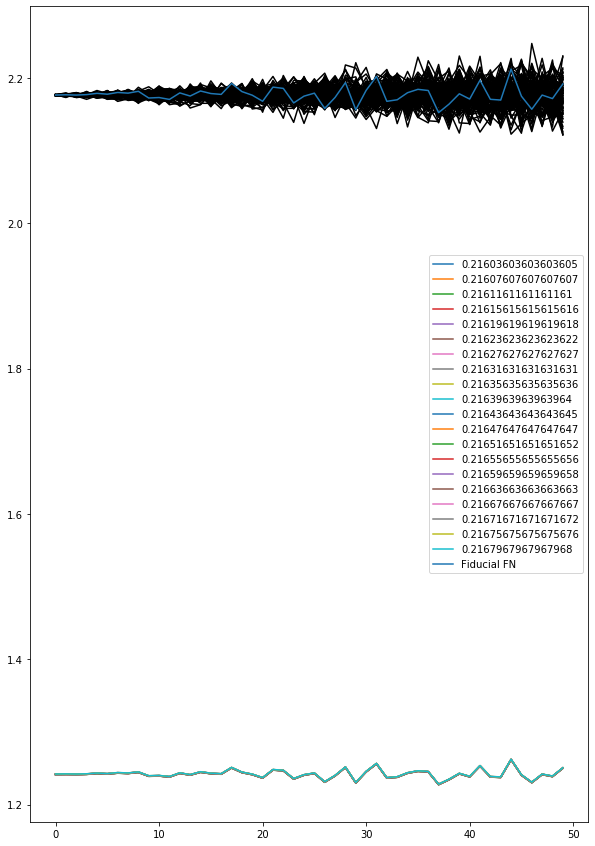

In [8]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(100):
    plt.plot(np.arange(n_vec), d_vec[index], color='k')
    #plt.semilogy(np.arange(n_vec), d_vec_q[index], label=q_prior[index])
for index in range(900, 920):
    #plt.semilogy(np.arange(n_vec), np.mean(d_vec[index::n_class], axis=0), label=q_prior[index])
    #plt.plot(np.arange(n_vec), d_vec_q_posterior[index], label=q_posterior[index])
    plt.plot(np.arange(n_vec), d_vec_q[index], label=q_prior[index])
plt.plot(np.arange(n_vec), d_vec_q_shift[0], label='Fiducial FN')
plt.legend();

In [9]:
# we test here whether it could be better to gaussianise data
# which are not at the fiducial point of the score compression
#d_vec = []
#for _ in range(n):
#    d_vec.append([np.random.lognormal(0.2, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])
#d_vec = np.reshape(np.asarray(d_vec), [-1, n_vec])

# we also create the data corresponding to fixed noise, at the fiducial q
#d_vec_q_shift = []
#for _ in range(1):
#    np.random.seed(13)
#    d_vec_q_shift.append([np.random.lognormal(0.2, (i/n_vec)/100.0, 1) for i in range(n_vec)])

#d_vec_q_shift = np.reshape(np.asarray(d_vec_q_shift), [-1, n_vec])

#d_vec_keep_copy = np.copy(d_vec)
#d_vec_shift_keep_copy = np.copy(d_vec_q_shift)

d_vec = []
for _ in range(n):
    d_vec.append([np.random.lognormal(0.5, (i+1)/(n_vec*100.0), 1) for i in range(n_vec)])
    
d_vec = np.reshape(np.asarray(d_vec), [-1, n_vec])

# we also create the data corresponding to fixed noise, at the fiducial q
d_vec_q_shift = []
for _ in range(1):
    np.random.seed(13)
    d_vec_q_shift.append([np.random.lognormal(0.5, (i/n_vec)/100.0, 1) for i in range(n_vec)])

d_vec_q_shift = np.reshape(np.asarray(d_vec_q_shift), [-1, n_vec])


In [10]:
# we need to retrieve all the needed summaries here, so:
# 1) the summaries of the fixed noise vectors
# 2) the summary of the observation
# 3) the summaries of the noise realisations at the fiducial point
# 4) the summary of the shift vector, i.e. the fixed noise at the fiducial value
summaries_posterior = []
for index in range(n_sims):
    summaries_posterior.append(compressor(d_vec_q[index]))  # it should be around 0.2, but just for display purpose
summaries_posterior = np.asarray(summaries_posterior)
summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec[index]))  # it should be at 0.5
summaries_noise = np.asarray(summaries_noise)
#summaries_noise_kept = []
#for index in range(n):
#    summaries_noise_kept.append(compressor(d_vec_keep_copy[index]))
#summaries_noise_kept = np.asarray(summaries_noise_kept)
summary_obs = compressor(d_vec_obs[0])  # it should be at 0.2
summary_obs = np.reshape(summary_obs, [1, 1])
summary_shift = compressor(d_vec_q_shift[0])  # it should be at 0.5
summary_shift = np.reshape(summary_shift, [1, 1])
#summary_shift_kept = compressor(d_vec_shift_keep_copy[0])
#summary_shift_kept = np.reshape(summary_shift_kept, [1, 1])

In [11]:
# now we plot a few things to make sure everything makes sense

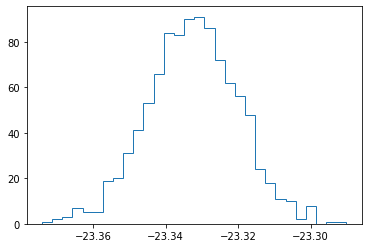

In [12]:
# first we plot the distribution of the noisy summaries
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step');

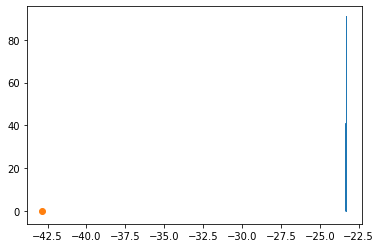

In [13]:
# we also check if the observation is within the summaries of the fiducial noisy data
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step')
plt.scatter(summary_obs, np.zeros(1));

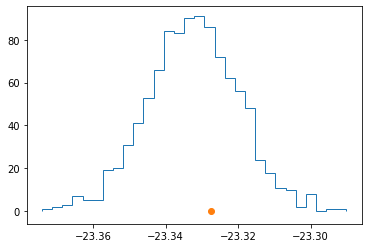

In [14]:
# we also check if the shift FN is within the summaries of the fiducial noisy data
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step')
plt.scatter(summary_shift, np.zeros(1))

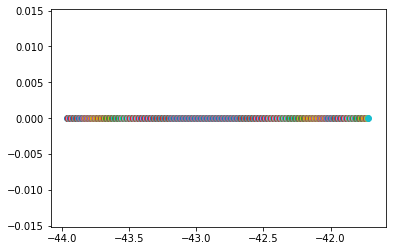

In [17]:
# and finally we look at the "posterior distribution"
# then we plot the distribution of the noisy summaries with all the FN summaries
for index in range(n_sims):
    plt.scatter(summaries_posterior[index], np.zeros(1))

# Gaussianisation of the latent space

At this stage, we finally need to set up the NF between the obtaines sample of summaries, in order to have the bijection to that space. We will use Inverse Autoregressive Flows (IAFs).

In [15]:
# we define a few variables here, and reset the graph
DTYPE=tf.float32
NP_DTYPE=np.float32
tf.reset_default_graph()
batch_size = 128
num_bijectors = 8

# we transform the summaries to a TF dataset object
dataset = tf.data.Dataset.from_tensor_slices(summaries_noise.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=summaries_noise.shape[0])
dataset = dataset.prefetch(3 * batch_size)
dataset = dataset.batch(batch_size)
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [16]:
# this is the distribution to match
#base_dist = tfd.Normal(loc=0.0, scale=1.0)
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([1], DTYPE))

In [17]:
# we define the flow here
bijectors = []
for i in range(num_bijectors):
    bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[1024, 1024]))))
    bijectors.append(tfb.Permute(permutation=[0]))
# discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [18]:
# this is the transformed distribution, i.e. the distribution of the summaries
dist = tfd.TransformedDistribution(
            distribution=base_dist,
            bijector=flow_bijector)

In [19]:
# optimisation
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

Instructions for updating:
Please use `layer.__call__` method instead.


In [ ]:
# and finally we train the NF as well
sess = tf.Session()
sess.run(tf.global_variables_initializer())
NUM_STEPS = 20000#int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 10 == 0:
        global_step.append(i)
        losses.append(np_loss)
        #g_losses.append(gl)
    if i % int(5e2) == 0:
        print(i, np_loss)
start = 0
plt.plot(global_step, losses[start:])

0 273.1805
500 10.650679
1000 4.575108
1500 3.4452128
2000 3.1645265
2500 3.0674236
3000 2.9931602
3500 2.9059854
4000 2.799438
4500 2.6708455
5000 2.5170147
5500 2.3335905
6000 2.113862
6500 1.845991
7000 1.5089859
7500 1.066822
8000 0.45950514
8500 -0.39938575
9000 -1.4454087
9500 -2.2122736
10000 -2.6249776
10500 -2.72652
11000 -2.7816584
11500 -2.9240637
12000 -2.8168104
12500 -2.7344103
13000 -3.0423422
13500 -2.8269038
14000 -2.8973205
14500 -2.995152
15000 -2.9779944
15500 -2.9508872
16000 -2.8630164
16500 -2.933978
17000 -2.938251
17500 -2.9237418


In [ ]:
# now we need to look at samples which we inject in the flow to the Gaussian domain
# just to make sure the gaussianisation was successful

In [ ]:
# we look at the flow injection, which corresponds to the inverse pass
x = x_samples
samples = [x]
names = [base_dist.name]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
    names.append(bijector.name)
samples_plot = [samples[0], samples[-1], base_dist.sample(128)]
names=['Latent', 'Mapped latent', 'Original Gaussian']

In [ ]:
noise_flow = sess.run(samples_plot)
f, arr = plt.subplots(1, len(noise_flow), figsize=(4 * (len(noise_flow)), 4))
X0 = noise_flow[0]
for i in range(len(noise_flow)):
    X1 = noise_flow[i]
    arr[i].scatter(X1, np.zeros_like(X1), s=10)
    arr[i].set_title(names[i])

In [ ]:
print(noise_flow[0].mean())
print(noise_flow[1].mean())
print(noise_flow[2].mean())
print(noise_flow[0].std())
print(noise_flow[1].std())
print(noise_flow[2].std())

In [28]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summary_obs.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_obs = data_iterator.get_next()

In [29]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summaries_posterior.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * n_sims)
dataset = dataset.batch(n_sims)
data_iterator = dataset.make_one_shot_iterator()
x_samples_posterior = data_iterator.get_next()

In [37]:
# we inject the shift as well
dataset = tf.data.Dataset.from_tensor_slices(summary_shift.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_shift = data_iterator.get_next()

In [38]:
# we inject the FN observation in the flow, since we need the fiducial one for the posterior evaluation
x = x_samples_shift
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
shift_flow_ = samples[-1]
shift = sess.run(shift_flow_)

In [39]:
shift

array([[-12.069053]], dtype=float32)

In [40]:
# we inject the posterior points
x = x_samples_posterior
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
posterior_points_ = samples[-1]
posterior_points = sess.run(posterior_points_)

In [54]:
# check that there are no duplicates
posterior_points__ = list(np.reshape(posterior_points, [-1]))

import collections
print ([item for item, count in collections.Counter(posterior_points__).items() if count > 1])

[]


In [41]:
# we need to shift the posterior points as we want the mean to be captured, and they have fixed noise
posterior_points_mu = posterior_points - shift[0][0]

In [42]:
# finally, we try to evaluate the posterior
# we first inject the observation in the flow as well
x = x_samples_obs
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
observation_ = samples[-1]
compressed_obs = sess.run(observation_)

In [43]:
compressed_obs[0][0]

-22.608093

In [44]:
# finally we evaluate the likelihood
from scipy.stats import norm as normal
likelihood_arr = np.zeros((n_sims, 2))
for index, mu in enumerate(posterior_points_mu):
    like_value = normal.pdf(compressed_obs[0][0], loc=mu, scale=1)
    likelihood_arr[index, :] = q_posterior[index], like_value


In [45]:
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [46]:
d_vec_obs_keep[0]

array([1.22140276, 1.22132149, 1.22121494, 1.22101417, 1.22272289,
       1.22386664, 1.22131844, 1.22236868, 1.22210557, 1.22027771,
       1.22012544, 1.22010996, 1.21577535, 1.21899972, 1.22295462,
       1.2247871 , 1.2205926 , 1.21984265, 1.2242196 , 1.23097192,
       1.21687568, 1.21743529, 1.21905572, 1.22448509, 1.2164054 ,
       1.22424985, 1.21683205, 1.22511683, 1.21925107, 1.2183611 ,
       1.22739001, 1.21245885, 1.21540917, 1.22729492, 1.22778066,
       1.2231807 , 1.2023197 , 1.22794562, 1.22464439, 1.21818102,
       1.20254107, 1.22975311, 1.2394821 , 1.2266781 , 1.23578549,
       1.21419626, 1.22348275, 1.21395068, 1.2083347 , 1.217261  ])

In [47]:
# now we need to plot all of this
# we first calculate the real posterior, and the one obtained from the data

def lognorm(data, mean, sigma):
    pref = data*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(data)-mean)**2 / (2*sigma**2))
    return expo/pref

def real_post(sigma, mean, obs):
    pref = obs*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(obs)-mean)**2 / (2*sigma**2))
    evidence = 1 #inc_gamma(0, np.log(obs)**2 / 2) / (2*obs*np.sqrt(2*np.pi))
    return (expo/pref)/(evidence)

def find_level(nums, level):
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num

real_posterior = 1
q_real = q_posterior[:]
for i, d in enumerate(d_vec_obs_keep[0]):
    real_posterior *= real_post((i+1)/(n_vec*100.0), q_real, d)

real_posterior = real_posterior / real_posterior.sum()

indexs_to_order_by = q_real.argsort()
q_real = q_real[indexs_to_order_by]
real_posterior = real_posterior[indexs_to_order_by]

posterior = []
for value in q_posterior:
    likelihood = 1
    for i, d in enumerate(d_vec_obs_keep[0]):
        likelihood *= lognorm(d, value, (i+1)/(n_vec*100.0))
    posterior.append(likelihood)

posterior = np.reshape(np.asarray(posterior), [n_sims])
# order points by their x-value
indexs_to_order_by = q_posterior.argsort()
q_posterior = q_posterior[indexs_to_order_by]
posterior = posterior[indexs_to_order_by]

# normalise output
normalisation = np.sum(posterior)
posterior = np.asarray(posterior)/normalisation

# we want to draw 68% confidence intervals here, and we start by
# finding the level corresponding to that
sorted_posterior = sorted(posterior, reverse=True)
# we should now start summing the elements in this sorted list,
# and stop when we reach the desired level, usually 68 or 95
req_level = 0.68
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_sims
condition = np.where(posterior >= rep_level, 1, -1)
try:
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0


(0.199, 0.201)

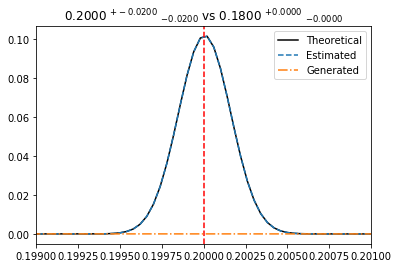

In [51]:
plt.plot(q_real, real_posterior, c='k', label='Theoretical')
plt.plot(q_posterior, posterior, linestyle='--', label='Estimated')
#plt.fill_between(q_posterior[id1:id2+1], posterior[id1:id2+1],  alpha=0.5, color='C0')
plt.axvline(q_fid, linestyle='--', color='r')
max_est = q_posterior[np.argmax(posterior)]
upp_bound = q_posterior[id2] - max_est
low_bound = max_est - q_posterior[id1]

# from the ML, with the corresponding error
# confidence levels of the generated one
sorted_posterior = sorted(likelihood_arr[:, 1], reverse=True)
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_sims
try:
    condition = np.where(likelihood_arr[:, 1] >= rep_level, 1, -1)
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
#plt.fill_between(likelihood_arr[id1:id2+1, 0], likelihood_arr[id1:id2+1, 1], alpha=0.5, color='C1')
max_est_gen = likelihood_arr[:, 0][np.argmax(likelihood_arr[:, 1])]
upp_bound_gen = likelihood_arr[:, 0][id2] - max_est_gen
low_bound_gen = max_est_gen - likelihood_arr[:, 0][id1]
plt.title(f'{max_est:.4f} $ ^{{ + {upp_bound:.4f} }}$ $ _{{ - {low_bound:.4f} }}$ vs {max_est_gen:.4f} $ ^{{ + {upp_bound_gen:.4f} }}$ $ _{{ - {low_bound_gen:.4f} }}$')
plt.legend()
plt.xlim([0.1990, 0.201])

In [23]:
# separate test for this case

In [41]:
def manual_gauss(data):
    return (data - summaries_noise.mean()) / summaries_noise.std()

noise_flow = manual_gauss(summaries_noise)
noise_flow_kept = manual_gauss(summaries_noise_kept)
compressed_obs = manual_gauss(summary_obs)
posterior_points = manual_gauss(summaries_posterior)
shift = manual_gauss(summary_shift)
posterior_points_mu = posterior_points  - shift
shift_kept = manual_gauss(summary_shift_kept)
posterior_point_mu_kept = shift_kept - shift

In [42]:
print(noise_flow.mean())
print(noise_flow.std())

1.4764722777727e-13
1.0


In [43]:
print(posterior_point_mu_kept[0][0])
print(noise_flow_kept.mean())
print(noise_flow_kept.std())

-1560.464529571739
-1560.3625998472355
0.7408182206816761


In [27]:
compressed_obs

array([[1927.15088752]])

In [28]:
# finally we evaluate the likelihood
from scipy.stats import norm as normal
likelihood_arr = np.zeros((n_sims, 2))
for index, mu in enumerate(posterior_points_mu):
    like_value = normal.pdf(compressed_obs[0][0], loc=mu, scale=1)
    likelihood_arr[index, :] = q_posterior[index], like_value
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [29]:
# now we need to plot all of this
# we first calculate the real posterior, and the one obtained from the data
from scipy.stats import lognorm

def lognorm_(data, mean, sigma):
    if sigma == 0:
        return np.exp(mean)
    pref = data*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(data)-mean)**2 / (2*sigma**2))
    return expo/pref

def real_post(sigma, mean, obs):
    if sigma == 0:
        return np.exp(mean)
    pref = obs*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(obs)-mean)**2 / (2*sigma**2))
    evidence = 1 #inc_gamma(0, np.log(obs)**2 / 2) / (2*obs*np.sqrt(2*np.pi))
    return (expo/pref)/(evidence)

def find_level(nums, level):
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num

q_real = q_posterior[:]
real_posterior = []
for q in q_real:
    real_posterior_ = 1
    for i, d in enumerate(d_vec_obs_keep[0]):
        real_posterior_ *= lognorm.pdf(d, s=(i+1)/(n_vec*100.0), loc=0, scale=np.exp(q))
    real_posterior.append(real_posterior_)

real_posterior = np.reshape(np.asarray(real_posterior), [n_sims])
real_posterior = real_posterior / real_posterior.sum()

indexs_to_order_by = q_real.argsort()
q_real = q_real[indexs_to_order_by]
real_posterior = real_posterior[indexs_to_order_by]

posterior = []
for value in q_posterior:
    likelihood = 1
    for i, d in enumerate(d_vec_obs_keep[0]):
        #likelihood *= lognorm(d, value, (i)/(n_vec*100.0))
        likelihood *= lognorm.pdf(d, s=(i+1)/(n_vec*100.0), loc=0, scale=np.exp(value))
    posterior.append(likelihood)

posterior = np.reshape(np.asarray(posterior), [n_sims])
# order points by their x-value
indexs_to_order_by = q_posterior.argsort()
q_posterior = q_posterior[indexs_to_order_by]
posterior = posterior[indexs_to_order_by]

# normalise output
normalisation = np.sum(posterior)
posterior = np.asarray(posterior)/normalisation

# we want to draw 68% confidence intervals here, and we start by
# finding the level corresponding to that
sorted_posterior = sorted(posterior, reverse=True)
# we should now start summing the elements in this sorted list,
# and stop when we reach the desired level, usually 68 or 95
req_level = 0.68
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_sims
try:
    condition = np.where(posterior >= rep_level, 1, -1)
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0

(0.777, 0.7785)

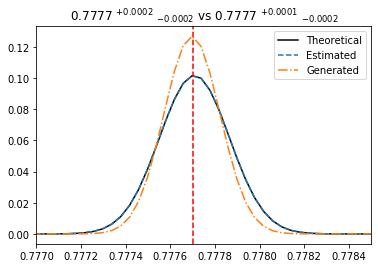

In [34]:
plt.plot(q_real, real_posterior, c='k', label='Theoretical')
plt.plot(q_posterior, posterior, linestyle='--', label='Estimated')
#plt.fill_between(q_posterior[id1:id2+1], posterior[id1:id2+1],  alpha=0.5, color='C0')
plt.axvline(q_fid, linestyle='--', color='r')
max_est = q_posterior[np.argmax(posterior)]
upp_bound = q_posterior[id2] - max_est
low_bound = max_est - q_posterior[id1]

# from the ML, with the corresponding error
# confidence levels of the generated one
sorted_posterior = sorted(likelihood_arr[:, 1], reverse=True)
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_sims
try:
    condition = np.where(likelihood_arr[:, 1] >= rep_level, 1, -1)
    id1_gen, id2_gen = np.argwhere(np.diff(condition)).flatten()
except:
    id1_gen, id2_gen = 0, 0
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
#plt.fill_between(likelihood_arr[id1_gen:id2_gen+1, 0], likelihood_arr[id1_gen:id2_gen+1, 1], alpha=0.5, color='C1')
max_est_gen = likelihood_arr[:, 0][np.argmax(likelihood_arr[:, 1])]
upp_bound_gen = likelihood_arr[:, 0][id2_gen] - max_est_gen
low_bound_gen = max_est_gen - likelihood_arr[:, 0][id1_gen]
plt.title(f'{max_est:.4f} $ ^{{ + {upp_bound:.4f} }}$ $ _{{ - {low_bound:.4f} }}$ vs {max_est_gen:.4f} $ ^{{ + {upp_bound_gen:.4f} }}$ $ _{{ - {low_bound_gen:.4f} }}$')
plt.legend()
plt.xlim([0.777, 0.7785])

# Posterior evaluation

After all we've done, we do have a tool that has gaussianised the likelihood. In fact, for a given parameter q, we can create an observation with fixed noise and feed it through the encoder+NF to get a point $y$. The likelihood is a unit Gaussian, with mean given by $\mu = y - z$, with $z$ the output of encoder+NF for the fiducial fixed noise realisation. In this sense, we only need to run 1 simulation per cosmological parameter.

A general observation, instead, is simply encoded and injected in the NF, thus getting the observed compressed data vector.

In order to check if we built a useful tool, we are going to calculate the posterior thus obtained. If this works, we can then build on top of this. But, as I expect, it does not work, well... we will need to re-think all of this.

In [44]:
# first thing we create an observation